# Evaluate performace of `kissim` vs. profiling datasets

Summarize ligand-kinase pair performances based on multiple profiling datasets:

- Profiling datasets: Karaman and Davis
- `kissim` datasets: Different feature weighting schemes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging
import math
import itertools

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from src import data
from src.evaluation.ligand_vs_kinase_evaluator import LigandVsKinaseEvaluator

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results_archive/20210810-2/dfg_in"

In [5]:
data.profiling.karaman_davis().unstack().dropna()

Karaman matrix: (268, 30)
Davis matrix: (350, 72)
Number of shared ligands: 22
Number of shared kinases: 265
Number of total ligands: 80
Number of total kinases: 353
Karaman-Davis matrix: (353, 80)
Karaman-Davis matrix: (353, 80)


Staurosporine  AAK1        1.2
               ABL1       22.0
               ABL2      110.0
               ACK        16.0
               ACTR2    8900.0
                         ...  
AZD-2171       TIE1      290.0
               TIE2      140.0
               TNIK      810.0
               TYRO3     830.0
               YES       260.0
Length: 7629, dtype: float64

## Define parameters

In [5]:
KINASE_DISTANCES_METHOD = "kissim"
KINASE_ACTIVITY_CUTOFF = 100
KINASE_ACTIVITY_MAX = True
MIN_N_SHARED_KINASES = 10
MIN_N_SHARED_ACTIVE_KINASES = 3

In [6]:
suffixes = ["15", "100", "001", "110", "011", "101", "111"]  # "010",
ligand_profiling_methods = ["karaman-davis"]

## Generate ROC/AUC data

### Ligand profiling method: karaman-davis

#### Kinase-kinase dataset: 15

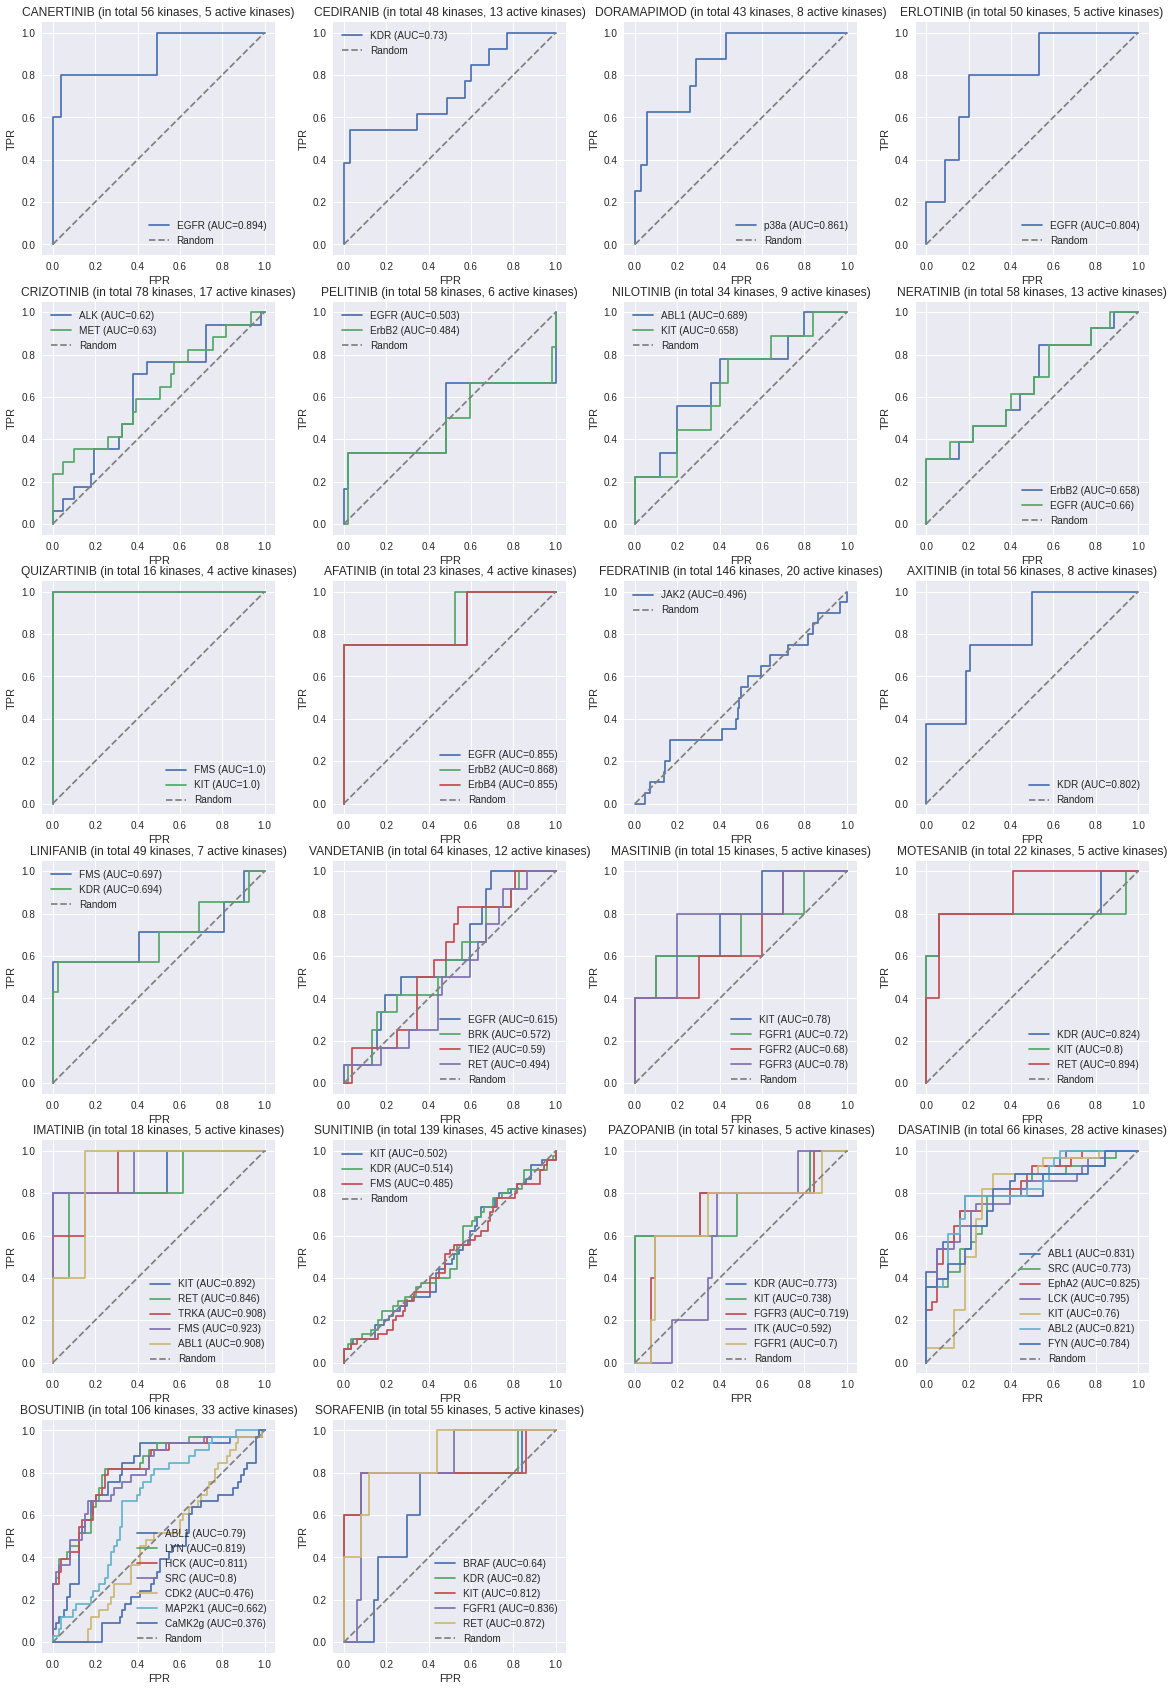

#### Kinase-kinase dataset: 100

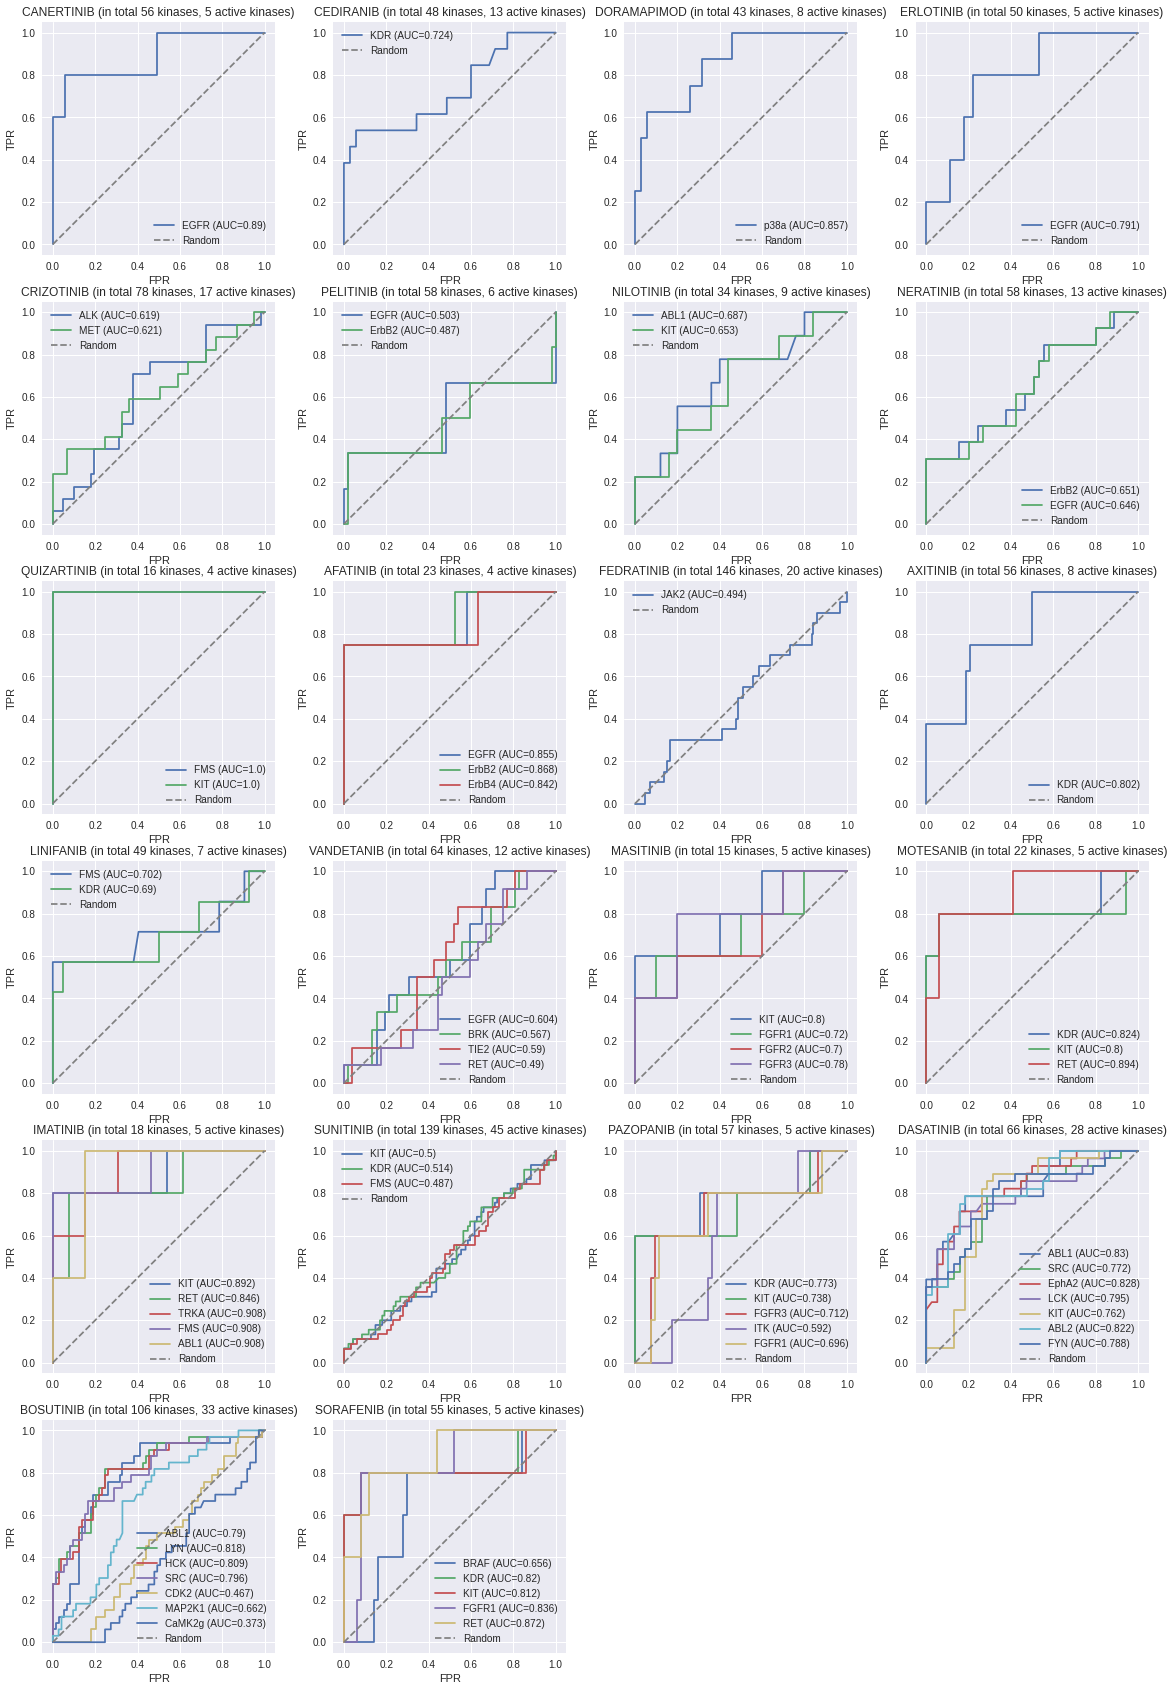

#### Kinase-kinase dataset: 001

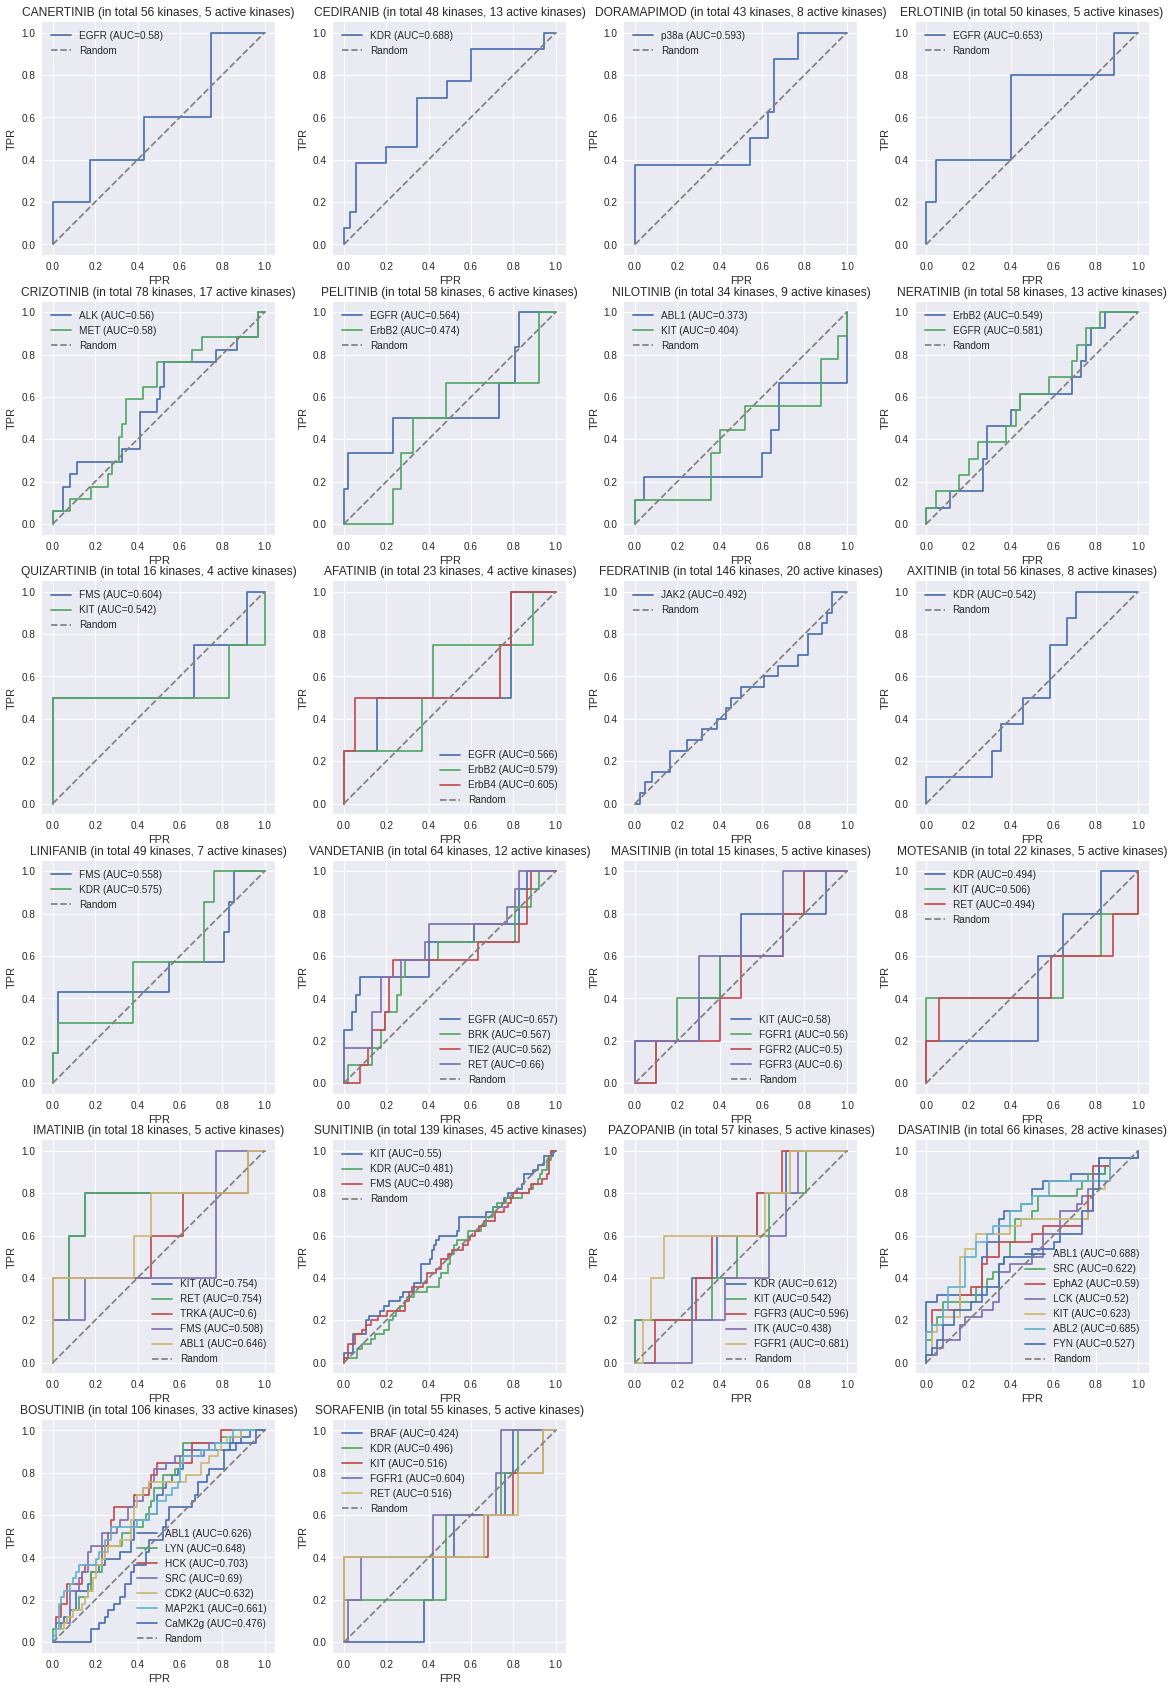

#### Kinase-kinase dataset: 110

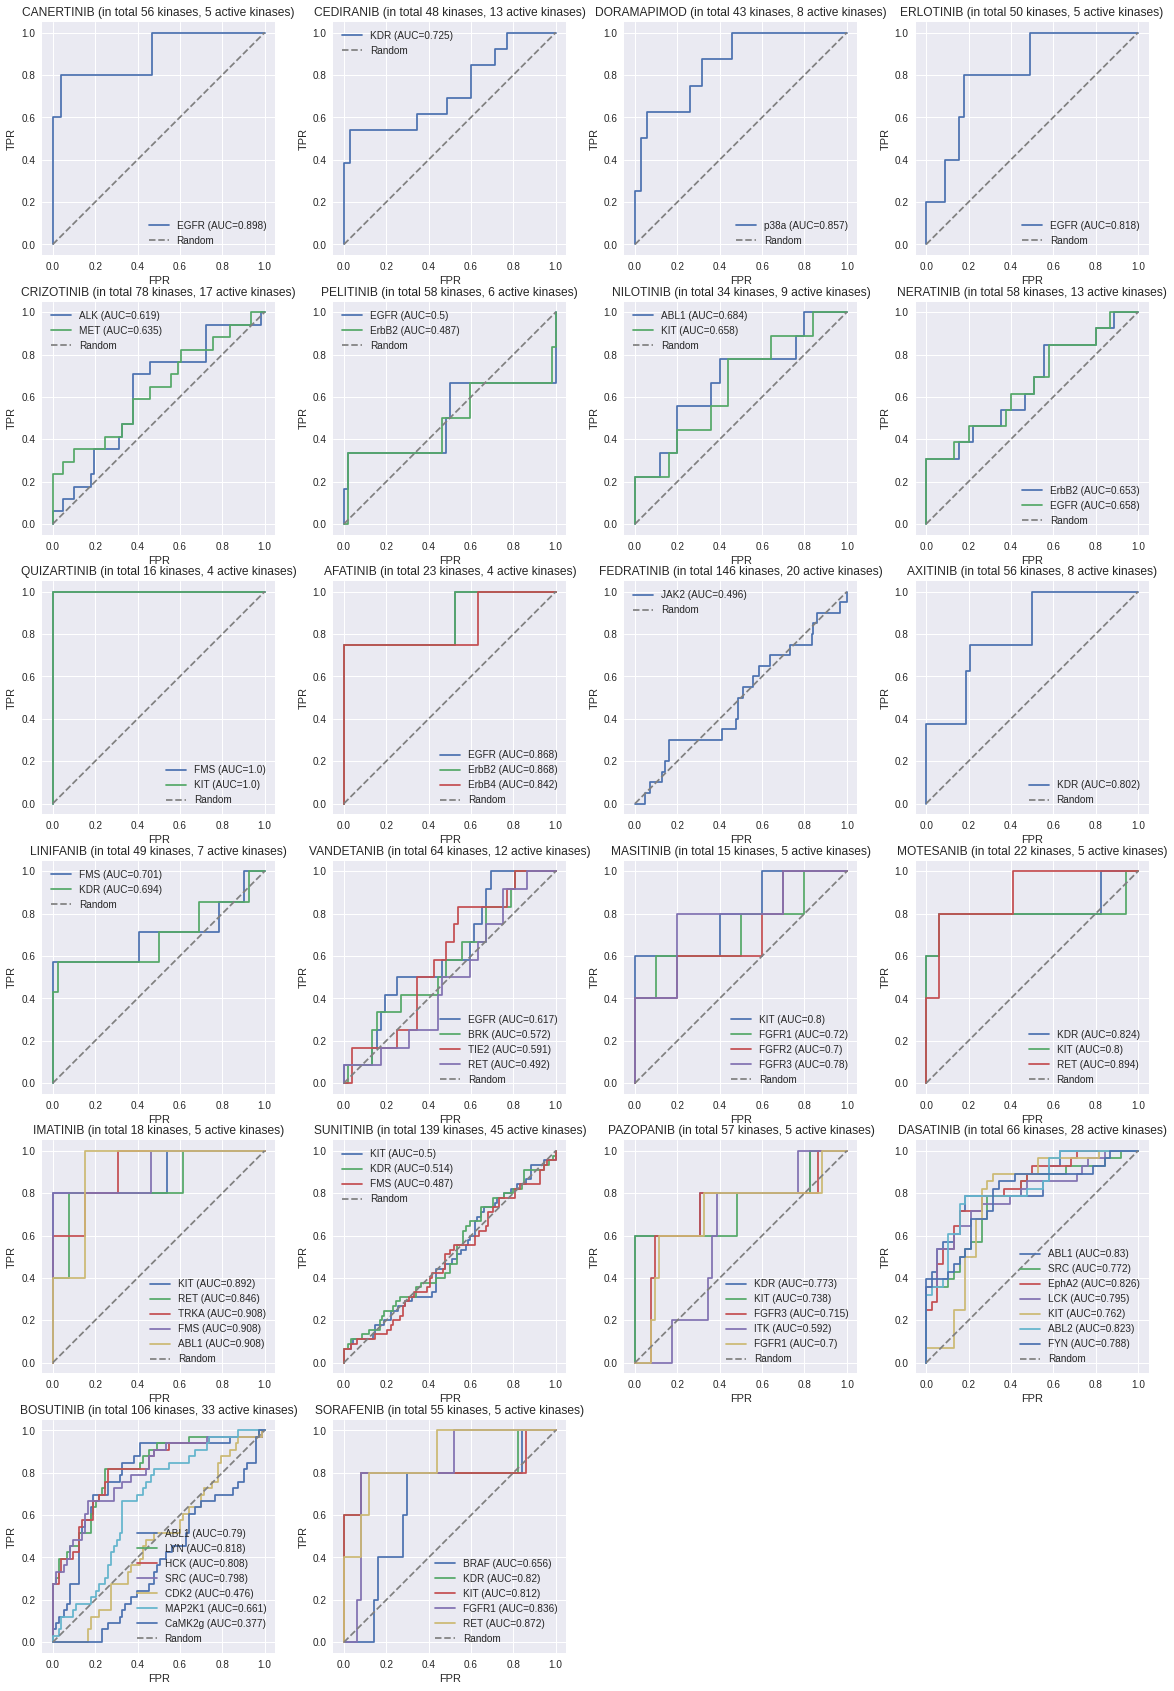

#### Kinase-kinase dataset: 011

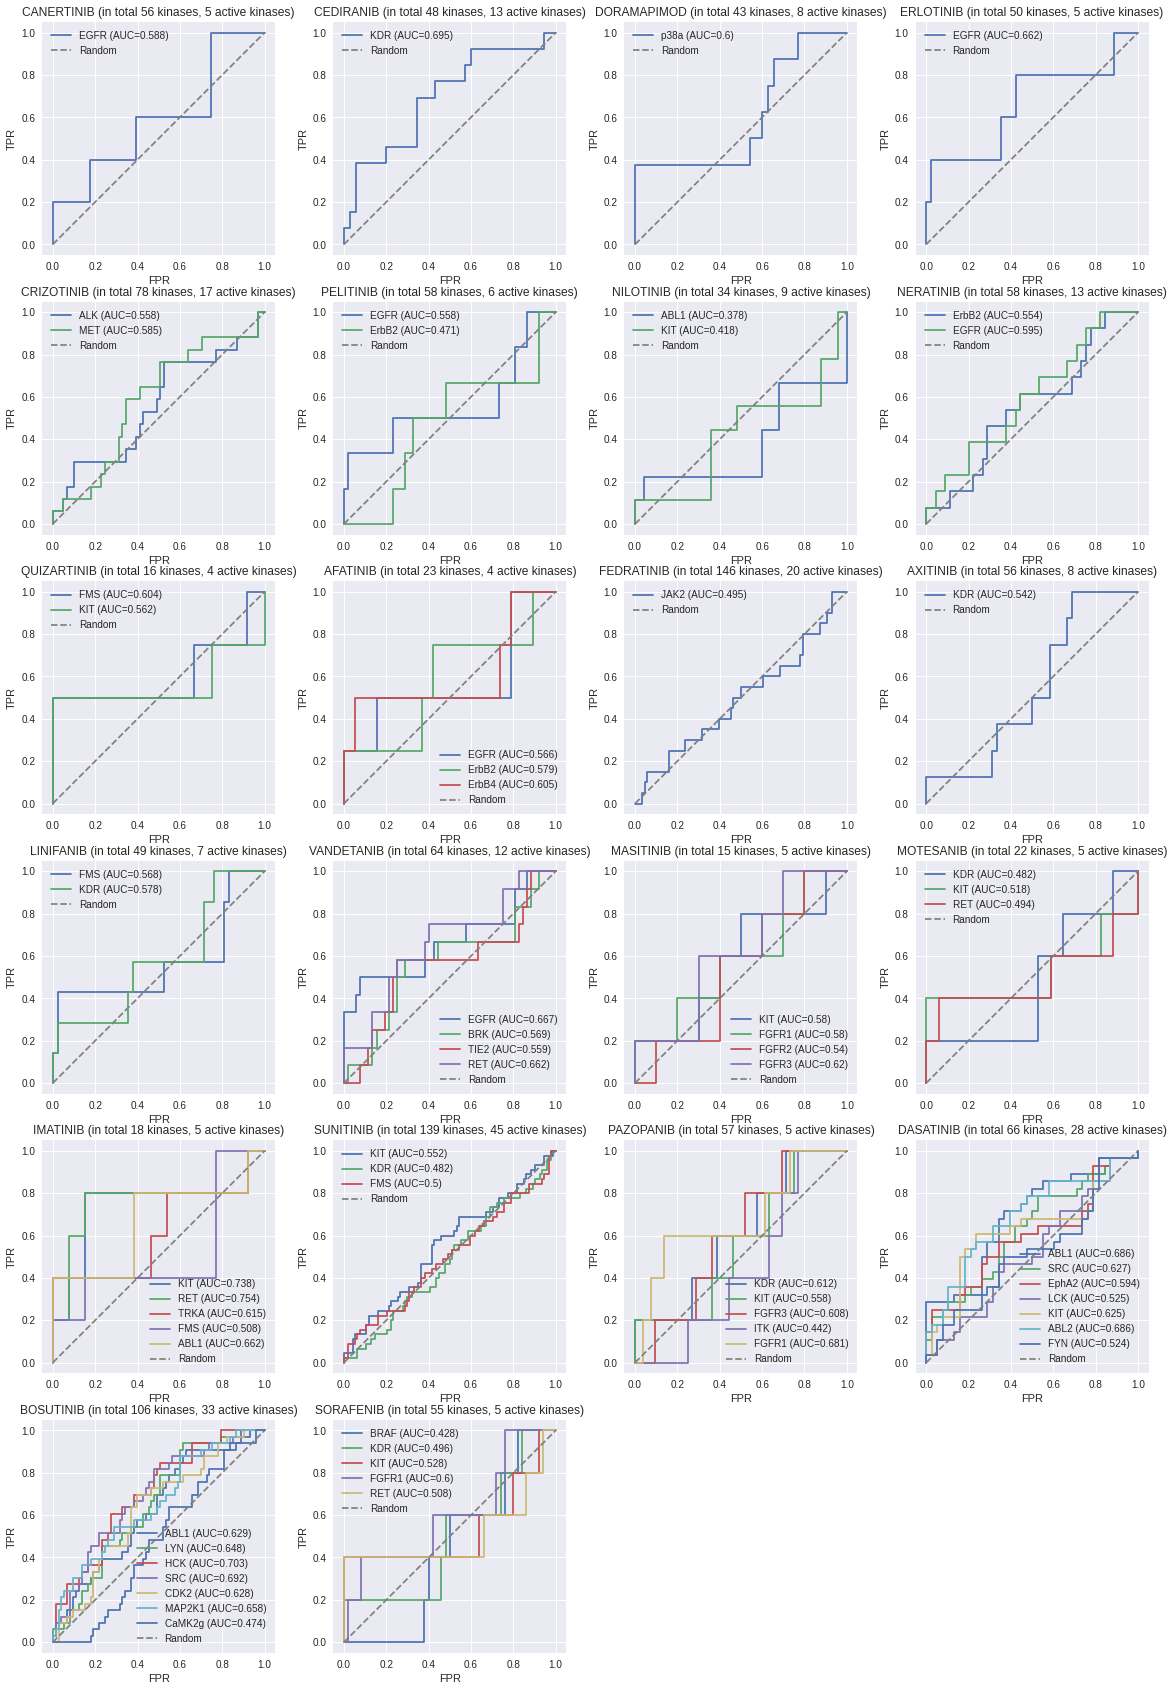

#### Kinase-kinase dataset: 101

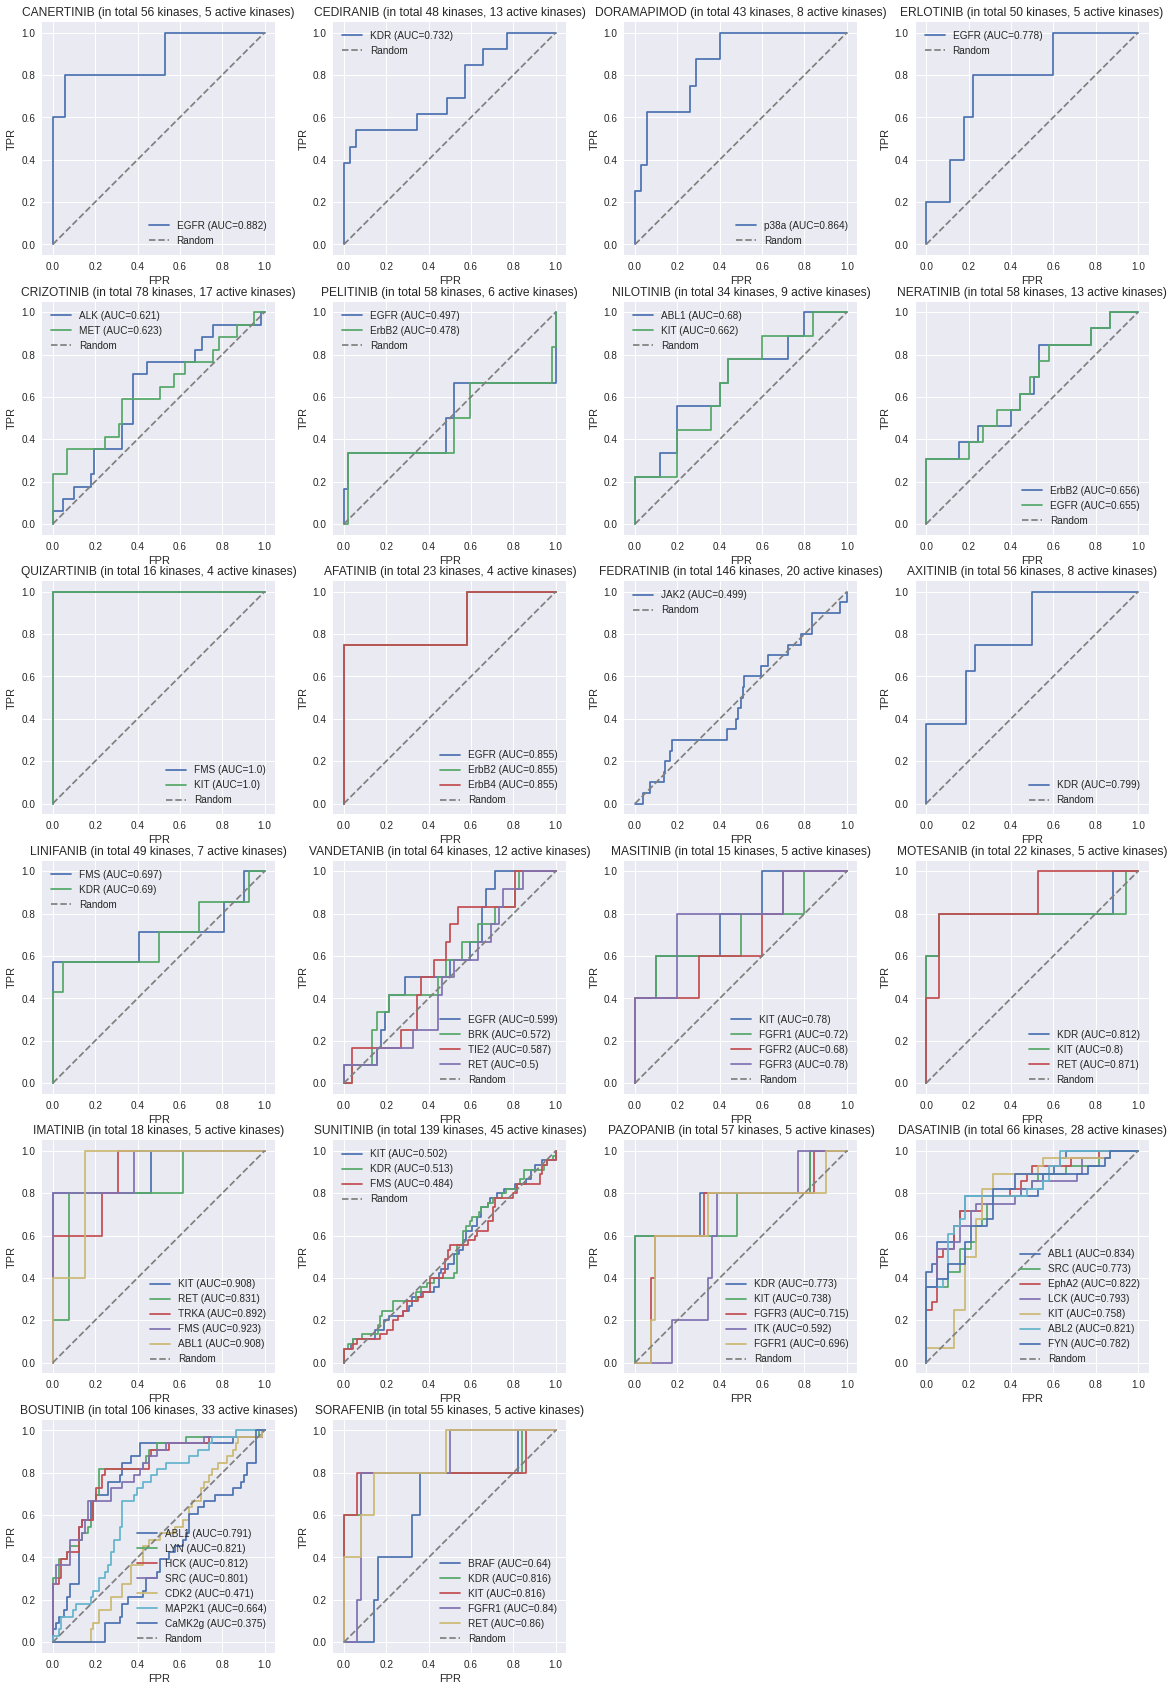

#### Kinase-kinase dataset: 111

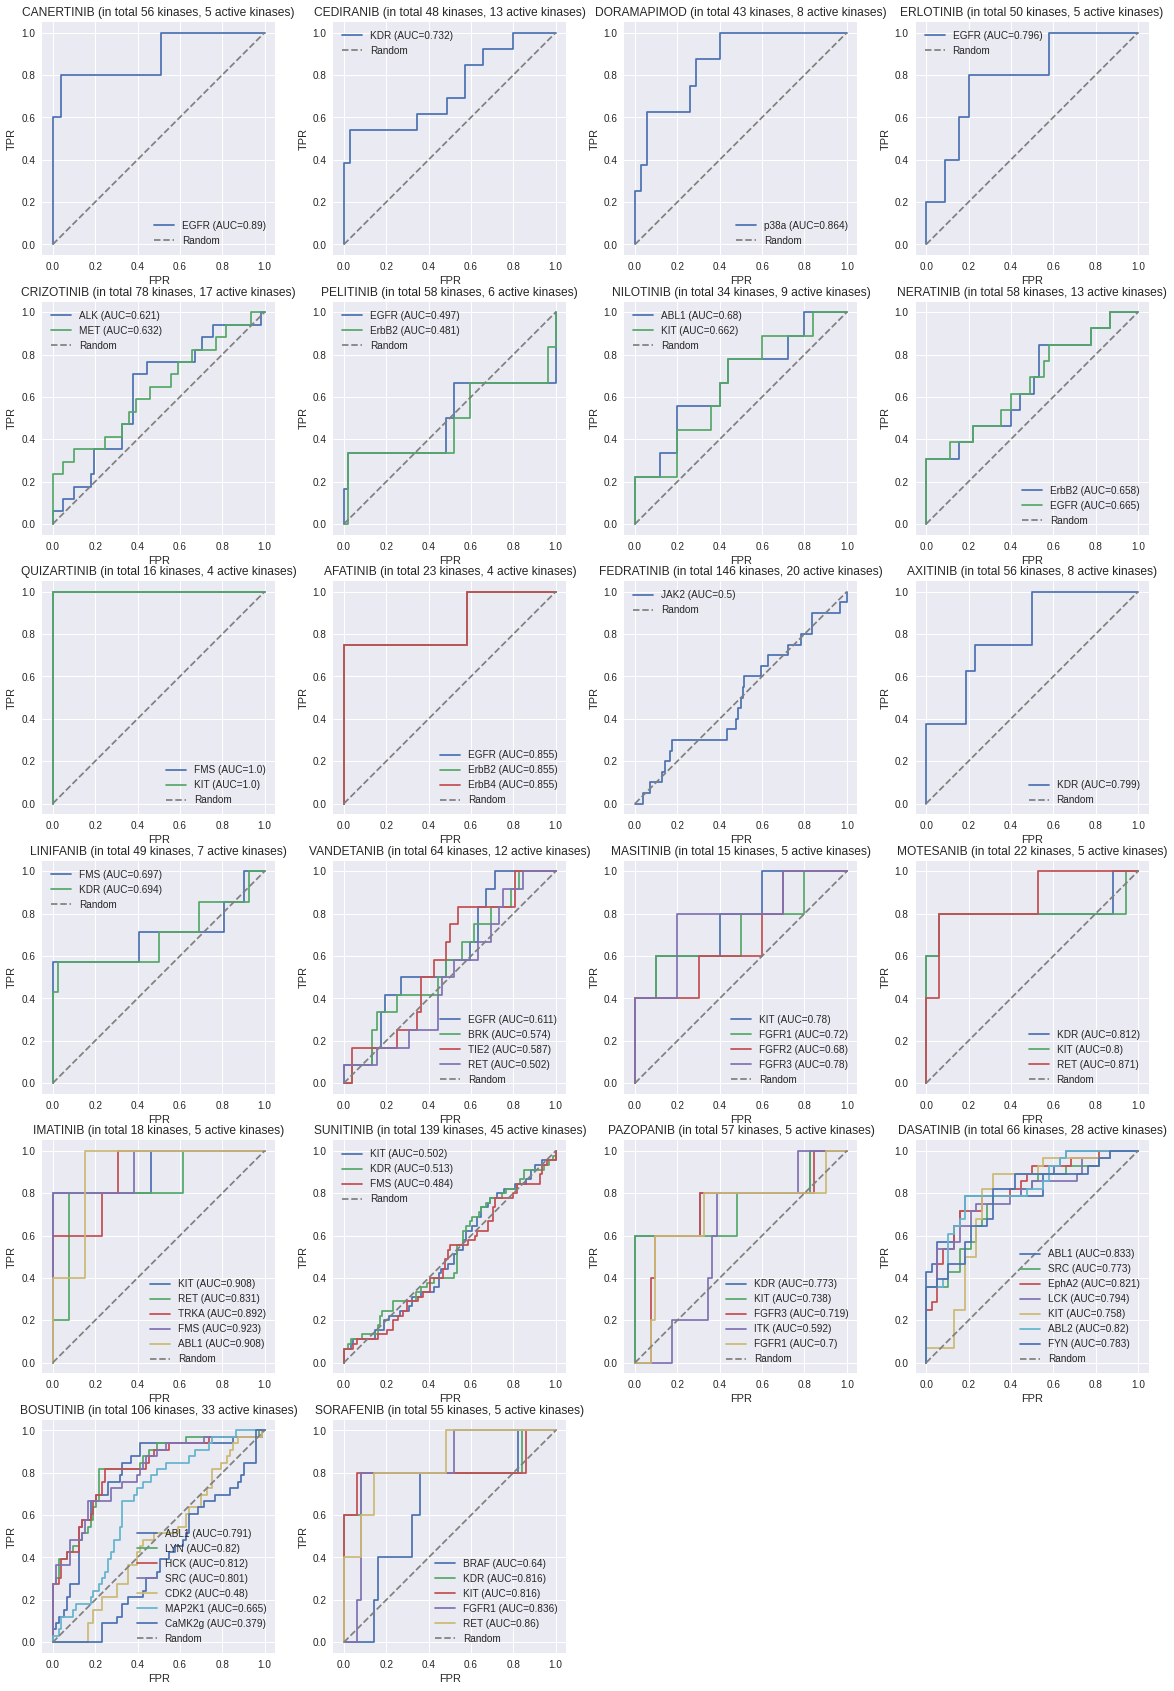

In [7]:
auc_dict = {}

for ligand_profiling_method in ligand_profiling_methods:
    display(Markdown(f"### Ligand profiling method: {ligand_profiling_method}"))
    auc_dict[ligand_profiling_method] = {}

    for suffix in suffixes:

        # Set path to file
        display(Markdown(f"#### Kinase-kinase dataset: {suffix}"))
        if suffix == "15":
            KINASE_KINASE_PATH = RESULTS / "fingerprint_distances.csv"
        else:
            KINASE_KINASE_PATH = RESULTS / f"fingerprint_distances_{suffix}.csv"

        # Kinase-kinase distances dataset
        kissim_df = data.distances.kissim(
            structure_kinase_mapping_by="minimum",
            kinmap_kinases=True,
            distances_path=KINASE_KINASE_PATH,
        )
        # Kinase-ligand profiling dataset
        profiling_df = data.profiling.load(
            ligand_profiling_method, pkidb_ligands=True, fda_approved=True
        )

        ligand_names = profiling_df.columns
        ligand_targets = data.targets.pkidb(ligand_names, fda_approved=False)
        ligand_kinase_pairs = (
            ligand_targets[["ligand.input", "targets.kinmap"]]
            .explode("targets.kinmap")
            .to_numpy()
            .tolist()
        )
        evaluator = LigandVsKinaseEvaluator(
            ligand_kinase_pairs,
            ligand_profiling_method,
            KINASE_DISTANCES_METHOD,
            KINASE_ACTIVITY_CUTOFF,
            KINASE_ACTIVITY_MAX,
            MIN_N_SHARED_KINASES,
            MIN_N_SHARED_ACTIVE_KINASES,
            kinase_kinase_path=KINASE_KINASE_PATH,
        )
        auc_list = evaluator.plot_roc_curves()
        # output_file = f"roc_{ligand_profiling_method}_{suffix}.png"
        # auc_list = evaluator.plot_roc_curves(output_file=output_file)
        plt.show()
        auc_dict[ligand_profiling_method][suffix] = auc_list

## Plot AUC distribution

### Ligand profiling method: karaman-davis

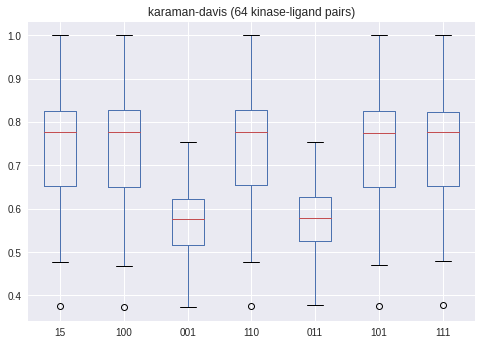

In [8]:
for profiling_name, auc in auc_dict.items():
    display(Markdown(f"### Ligand profiling method: {profiling_name}"))
    auc_df = pd.DataFrame(auc)
    auc_df.plot(kind="box", title=f"{profiling_name} ({auc_df.shape[0]} kinase-ligand pairs)")
    # plt.savefig(f"auc_{profiling_name}.png", bbox_inches="tight", dpi=300)
    plt.show()

In [9]:
auc_df.describe()

,15,100,001,110,011,101,111
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.734549,0.733362,0.574242,0.735241,0.578168,0.732000,0.733298
std,0.140837,0.141067,0.079876,0.140535,0.078967,0.140287,0.139429
min,0.375675,0.372976,0.373333,0.376505,0.377778,0.375259,0.378995
25%,0.653333,0.650000,0.516000,0.655248,0.525141,0.651026,0.653590
50%,0.776538,0.776538,0.576889,0.776538,0.579474,0.775637,0.776748
75%,0.826598,0.828125,0.623733,0.827068,0.627279,0.824469,0.823764
max,1.000000,1.000000,0.753846,1.000000,0.753846,1.000000,1.000000


In [10]:
auc_df.to_csv(RESULTS / "auc.csv", index=None)

## Scatter AUC values between weighting schemes

Use only best performing feature weights:

In [11]:
best_feature_weights = ["15", "100", "110", "101", "111"]

### Ligand profiling method: karaman-davis

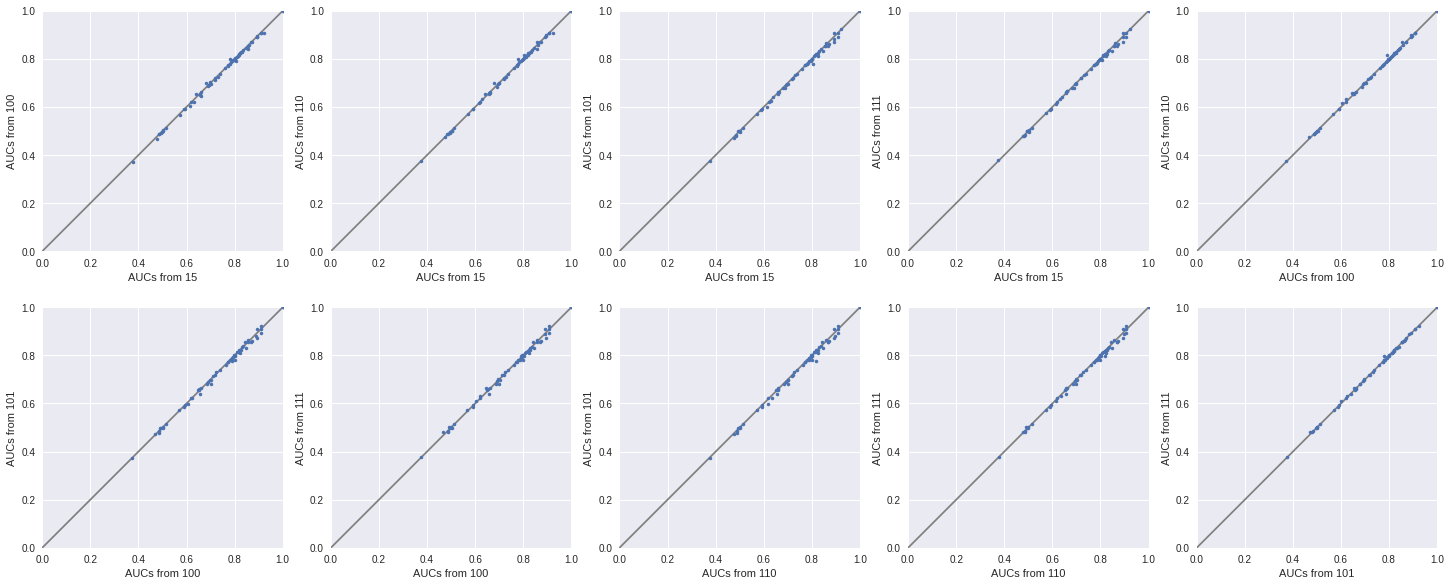

In [12]:
for profiling_name, auc in auc_dict.items():

    display(Markdown(f"### Ligand profiling method: {profiling_name}"))
    pairs = list(itertools.combinations(best_feature_weights, 2))
    n_cols = 5
    n_rows = math.ceil(len(pairs) / n_cols)
    _, axes = plt.subplots(figsize=(n_cols * 5, n_rows * 5), nrows=n_rows, ncols=n_cols)
    axes = axes.reshape(-1)

    for i, pair in enumerate(pairs):

        axes[i].plot([0, 1], [0, 1], "grey")
        axes[i].plot(auc_df[pair[0]], auc_df[pair[1]], ".")
        axes[i].set_box_aspect(1)
        axes[i].set_xlim([0, 1])
        axes[i].set_ylim([0, 1])
        axes[i].set_xlabel(f"AUCs from {pair[0]}")
        axes[i].set_ylabel(f"AUCs from {pair[1]}")

    plt.show()